# Live Detector

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import numpy as np
from IPython.display import display
import glob
import os
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from imutils.video import VideoStream
import imutils
from google.colab.patches import cv2_imshow
import cv2

## Face Mask with Face detection Haarcascade

### Face Mask Detection for Image

[[0.02342811]]
[[0.0352983]]


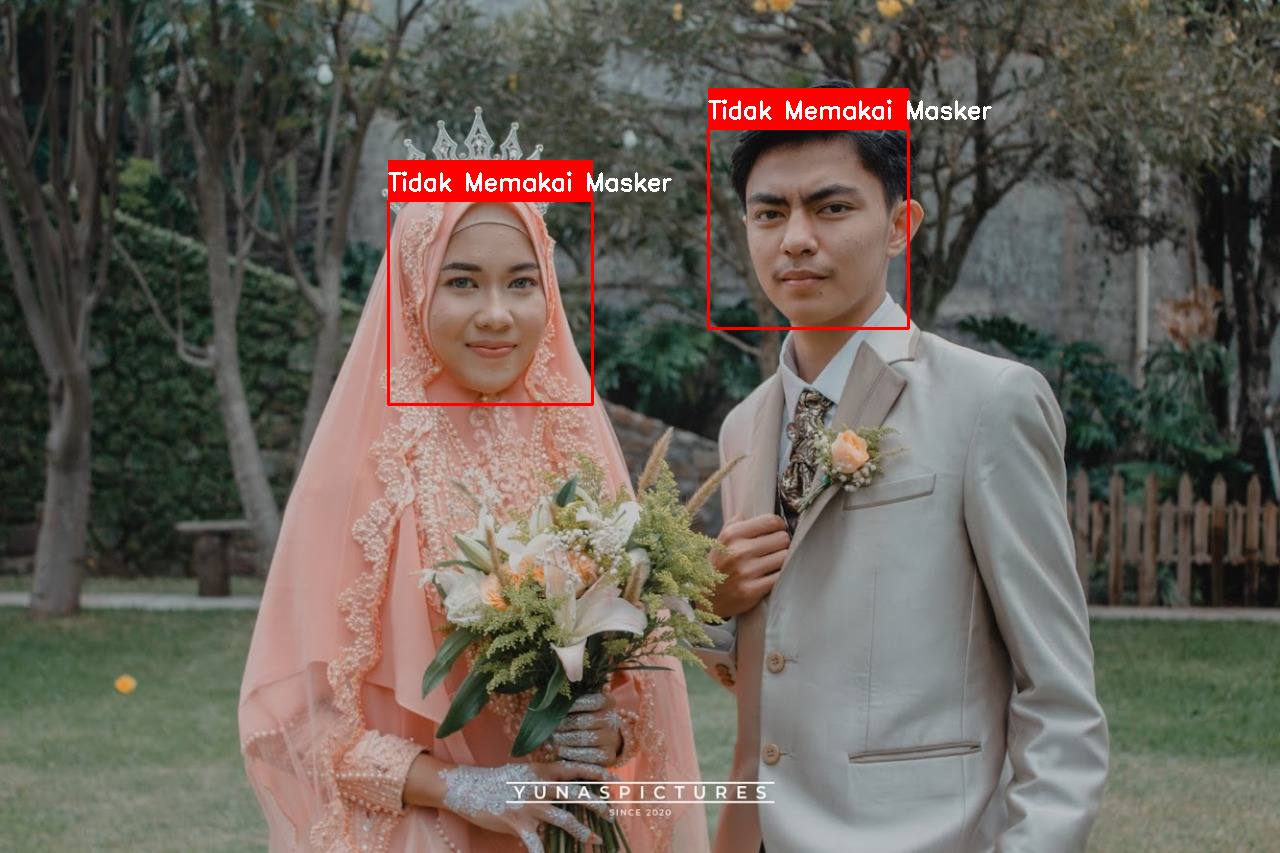

In [ ]:
labels_dict={0:'Tidak Memakai Masker',1:'Memakai Masker'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
image = cv2.imread('/content/img3.jpeg')

im = imutils.resize(image)
# im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# We load the xml file
classifier = cv2.CascadeClassifier('/content/drive/MyDrive/FaceMaskDetection/detector/haarcascade_frontalface_default.xml')
model = load_model('/content/drive/MyDrive/FaceMaskDetection/model_cnn.h5')

# Resize the image to speed up detection
mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

# detect MultiScale / faces 
faces = classifier.detectMultiScale(mini)

# Draw rectangles around each face
for f in faces:
  (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
  #Save just the rectangle faces in SubRecFaces
  face_img = im[y:y+h, x:x+w]
  # face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
  resized=cv2.resize(face_img,(224,224))
  normalized=resized/255.0
  reshaped=np.reshape(normalized,(1,224,224,3))
  reshaped = np.vstack([reshaped])
  result=model.predict(reshaped)
  print(result)
        
  label=np.argmax(result,axis=1)[0]
   
  cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
  cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
  cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
  # Show the image
cv2_imshow(im)

### Face Mask Detection for Video



In [ ]:
labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('/content/drive/MyDrive/FaceMaskDetection/detector/haarcascade_frontalface_default.xml')
model = load_model('/content/drive/MyDrive/FaceMaskDetection/model_cnn.h5')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

## Face Mask with Face detection CaffeModel

In [ ]:
model = load_model('/content/drive/MyDrive/FaceMaskDetection/model_cnn.h5')
prototxt_path = "/content/drive/MyDrive/FaceMaskDetection/detector/deploy.prototxt"
weight_path = "/content/drive/MyDrive/FaceMaskDetection/detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxt_path, weight_path)

In [ ]:
def detectMask(pic, faceNet, maskNet):
  (h, w) = pic.shape[:2]
  blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

  faceNet.setInput(blob)
  detections = faceNet.forward()
  
  for i in range(0, detections.shape[2]):
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    img = np.array(face, dtype='float')
    img = img.reshape(1, 224, 224, 3)

    preds = maskNet.predict(img)

    return ((startX, startY, endX, endY), preds[0][0])

 Wearing Mask


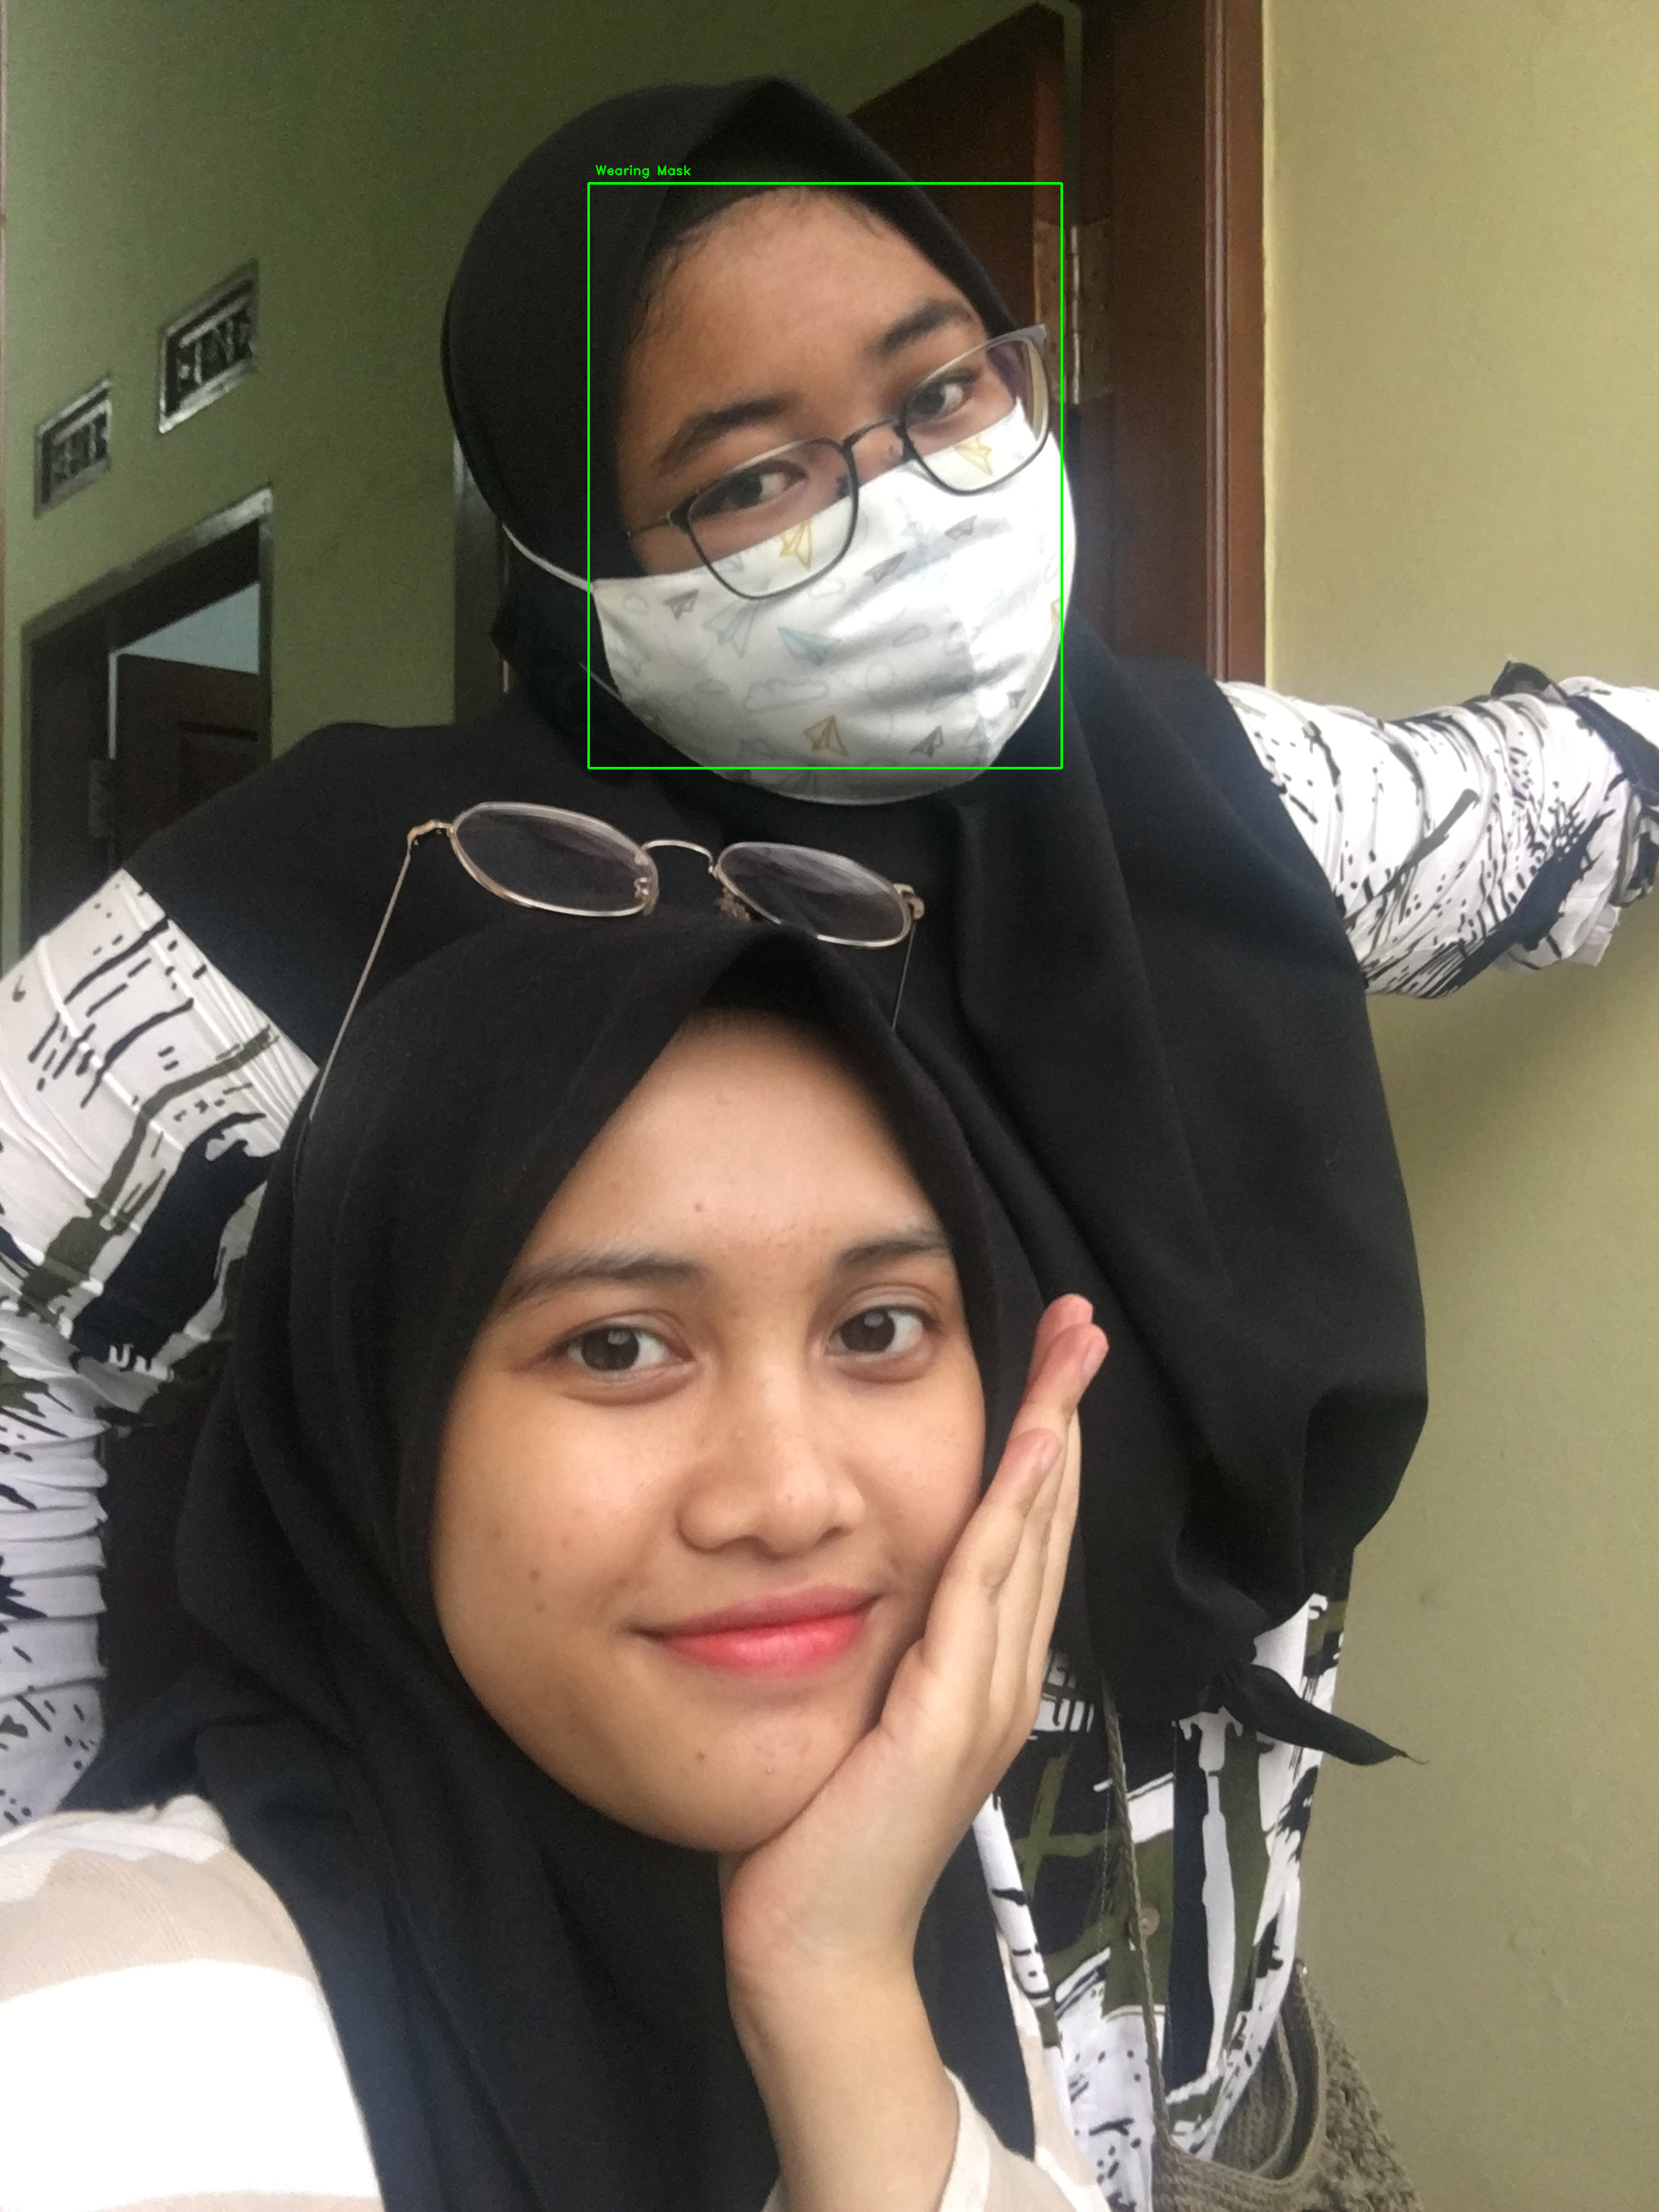

In [ ]:
image = cv2.imread('/content/IMG_0840.JPG')

image = imutils.resize(image)

(locs, preds) = detectMask(image, faceNet, model)

(startX, startY, endX, endY) = locs
result = preds

color = (0, 255, 0)
status =" Wearing Mask"
if (result == 1):
  status =" Not Wearing Mask"
  color = (0, 0, 255)

font = cv2.FONT_HERSHEY_DUPLEX

stroke = 1
cv2.putText(image, status, (startX, startY - 10), font, 0.5, color, stroke, cv2.LINE_AA)

stroke = 2
cv2.rectangle(image, (startX, startY), (endX, endY), color, stroke)

print(status)
cv2_imshow(image)